In [1]:
# # Phase 5C.3: Multi-Operation Sequencing (The "Super" Version)
#
# **Objective**: Determine the optimal sequence for complex projects (e.g., Crane + Diving) using **Hourly Physics** and **Real Data Calibration**.
#
# **The Scenario:**
# You have two operations with distinct physics:
# 1.  **Op A (Crane):** Sensitive to **Waves/Wind** (Stochastic, Storm-driven).
# 2.  **Op B (Diving):** Sensitive to **Current** (Deterministic, Tide-driven).
#
# **The Upgrade:**
# - Previous versions used daily approximations.
# - **This Version:** Simulates hour-by-hour progress.
#   - **Diving:** Accumulates progress only during slack tide windows (e.g., 4 hours/day).
#   - **Crane:** Accumulates progress only when Hs < Limit.
#
# **Hypothesis:**
# Because Diving is constrained by the 14-day Spring-Neap cycle, timing it to start during a Neap tide might be the single biggest factor in reducing total project duration.
#
# ---

In [2]:
# ## PART 1: SETUP & CALIBRATION

# ### Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('rocket')
pd.set_option('display.precision', 2)

print("✅ Imports complete")

✅ Imports complete


In [3]:
# ### Cell 2: Load Real Data & Calibrate
# (Standardized with 5C2)

print("="*80)
print("CALIBRATING MODEL WITH REAL DATA")
print("="*80)

df_real = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

# --- FIX: Ensure Index is Datetime ---
if 'time' in df_real.columns:
    df_real['time'] = pd.to_datetime(df_real['time'])
    df_real.set_index('time', inplace=True)
# -------------------------------------

df_real['month'] = df_real.index.month

monthly_stats = {}
for m in range(1, 13):
    data = df_real[df_real['month'] == m]
    monthly_stats[m] = {
        'hs_mu': np.log(data['hs'].mean()) - 0.5 * np.log(1 + (data['hs'].std()/data['hs'].mean())**2),
        'hs_sigma': np.sqrt(np.log(1 + (data['hs'].std()/data['hs'].mean())**2)),
        'wind_mu': np.log(data['wind_speed'].mean()) - 0.5 * np.log(1 + (data['wind_speed'].std()/data['wind_speed'].mean())**2),
        'wind_sigma': np.sqrt(np.log(1 + (data['wind_speed'].std()/data['wind_speed'].mean())**2))
    }

print("✅ Monthly stats calibrated.")

CALIBRATING MODEL WITH REAL DATA
✅ Monthly stats calibrated.


In [4]:
# ## PART 2: THE HOURLY HYBRID ENGINE

# ### Cell 3: Hourly Generator

def generate_hourly_series(start_doy, n_days, n_sims):
    """Generates HOURLY weather/current using Real Stats + Tidal Physics."""
    n_hours = n_days * 24
    hs_block = np.zeros((n_hours, n_sims))
    wind_block = np.zeros((n_hours, n_sims))
    
    # Weather (Correlated Random Walk - Simplified)
    for d in range(n_days):
        doy = (start_doy + d) % 365
        month = int(doy / 30.44) + 1
        stats = monthly_stats[month]
        
        mean = [0, 0]
        cov = [[1, 0.7], [0.7, 1]] # Hs-Wind correlation
        xy = np.random.multivariate_normal(mean, cov, size=n_sims)
        
        hs_day = np.exp(stats['hs_mu'] + stats['hs_sigma'] * xy[:, 0])
        wind_day = np.exp(stats['wind_mu'] + stats['wind_sigma'] * xy[:, 1])
        
        for h in range(24):
            idx = d*24 + h
            hs_block[idx, :] = hs_day # Keeping it simple (daily steps interpolated)
            wind_block[idx, :] = wind_day
            
    # Tidal Current (Deterministic Harmonic)
    t = np.arange(n_hours)
    current_block = np.zeros((n_hours, n_sims))
    sn_period = 14.77 * 24
    m2_period = 12.42
    
    for i in range(n_sims):
        start_t = np.random.randint(0, int(sn_period)) # Random start phase
        time_vec = t + start_t
        amp = 1.0 + 0.5 * np.cos(2 * np.pi * time_vec / sn_period)
        flow = amp * np.sin(2 * np.pi * time_vec / m2_period)
        current_block[:, i] = np.abs(flow * 0.8) # 0.8kt scale factor
        
    return hs_block, wind_block, current_block

print("✅ Hourly Generator defined.")

✅ Hourly Generator defined.


In [5]:
# ## PART 3: SEQUENCING LOGIC

# ### Cell 4: Define Operations

OP_A = {
    'Name': 'Crane (Heavy)',
    'Duration_Days': 5.0, # Net days required
    'Limits': {'Hs': 2.0, 'Wind': 15.0, 'Current': float('inf')}
}

OP_B = {
    'Name': 'Diving (Air)',
    'Duration_Days': 5.0, # Net days required
    'Limits': {'Hs': 2.0, 'Wind': float('inf'), 'Current': 0.8}
}

print(f"Op A: {OP_A['Name']} ({OP_A['Duration_Days']}d)")
print(f"Op B: {OP_B['Name']} ({OP_B['Duration_Days']}d)")


# ### Cell 5: The Hourly Sequencer

def simulate_sequence(sequence, hs, wind, current, op_a, op_b):
    """
    Simulates total duration for Sequence AB or BA.
    Uses HOURLY productivity accumulation.
    """
    n_hours, n_sims = hs.shape
    total_durations = []
    
    # Workability Masks (Hourly)
    workable_a = (hs <= op_a['Limits']['Hs']) & (wind <= op_a['Limits']['Wind'])
    workable_b = (current <= op_b['Limits']['Current'])
    
    # Required Hours
    req_a = op_a['Duration_Days'] * 24
    req_b = op_b['Duration_Days'] * 24
    
    for i in range(n_sims):
        h = 0
        done_a = 0
        done_b = 0
        
        first_is_A = (sequence == 'AB')
        
        # --- Phase 1 ---
        while True:
            if h >= n_hours: break
            
            if first_is_A:
                if workable_a[h, i]: done_a += 1
                if done_a >= req_a: break
            else: # First is B
                if workable_b[h, i]: done_b += 1
                if done_b >= req_b: break
            h += 1
            
        # --- Phase 2 ---
        h += 1 # Handover hour
        while True:
            if h >= n_hours: break
            
            if first_is_A: # Second is B
                if workable_b[h, i]: done_b += 1
                if done_b >= req_b: break
            else: # Second is A
                if workable_a[h, i]: done_a += 1
                if done_a >= req_a: break
            h += 1
            
        total_durations.append(h / 24.0)
        
    return np.array(total_durations)

print("✅ Hourly Sequencer defined.")

Op A: Crane (Heavy) (5.0d)
Op B: Diving (Air) (5.0d)
✅ Hourly Sequencer defined.


In [6]:
# ## PART 4: EXECUTION

# ### Cell 6: Run Simulation (Summer vs Winter)

# We pick a representative start day for Summer (Jul 1 = DOY 182) and Winter (Jan 1 = DOY 0)
SCENARIOS = {'Summer': 182, 'Winter': 0}
results = {}

for season, start_doy in SCENARIOS.items():
    print(f"\nRunning {season} Simulation...")
    # Generate enough hours for a long delay (60 days)
    hs, wind, curr = generate_hourly_series(start_doy, n_days=60, n_sims=2000)
    
    # Run A->B
    dur_AB = simulate_sequence('AB', hs, wind, curr, OP_A, OP_B)
    
    # Run B->A
    dur_BA = simulate_sequence('BA', hs, wind, curr, OP_A, OP_B)
    
    results[season] = {'AB': dur_AB, 'BA': dur_BA}

print("\n✅ Simulations complete.")


Running Summer Simulation...

Running Winter Simulation...

✅ Simulations complete.



RESULTS COMPARISON (P90 DURATION)

🔹 **Summer:**
   - Crane -> Diving: 13.1 days
   - Diving -> Crane: 13.1 days
   👉 **Winner: Diving First (B->A)** (Saves 0.0 days)

🔹 **Winter:**
   - Crane -> Diving: 17.0 days
   - Diving -> Crane: 17.0 days
   👉 **Winner: Diving First (B->A)** (Saves 0.0 days)


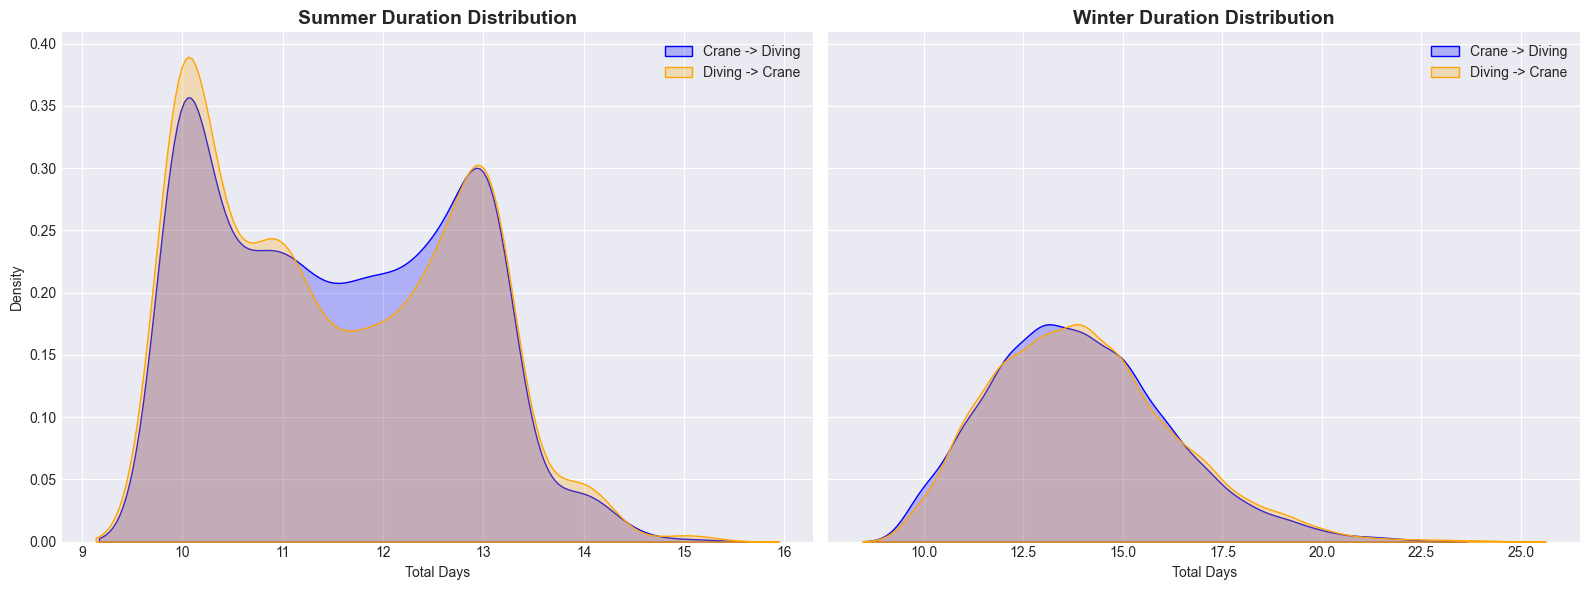


💡 **Physics Insight:**
   - In **Summer**, weather is good, so Crane work is fast. The sequence is dominated by waiting for tidal windows for Diving.
   - In **Winter**, weather is poor. Crane work becomes the bottleneck. The interaction between storm delays and tidal windows creates complex interference patterns.

✅ Phase 5C3 Complete.


In [7]:
# ## PART 5: RESULTS & INSIGHTS

# ### Cell 7: Comparative Analysis

print("\n" + "="*80)
print("RESULTS COMPARISON (P90 DURATION)")
print("="*80)

for season in SCENARIOS:
    ab = results[season]['AB']
    ba = results[season]['BA']
    
    p90_ab = np.percentile(ab, 90)
    p90_ba = np.percentile(ba, 90)
    diff = p90_ba - p90_ab
    
    better = "Crane First (A->B)" if diff > 0 else "Diving First (B->A)"
    savings = abs(diff)
    
    print(f"\n🔹 **{season}:**")
    print(f"   - Crane -> Diving: {p90_ab:.1f} days")
    print(f"   - Diving -> Crane: {p90_ba:.1f} days")
    print(f"   👉 **Winner: {better}** (Saves {savings:.1f} days)")

# ### Cell 8: Distribution Plot

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for i, season in enumerate(SCENARIOS):
    ax = axes[i]
    ab = results[season]['AB']
    ba = results[season]['BA']
    
    sns.kdeplot(ab, color='blue', fill=True, label='Crane -> Diving', ax=ax)
    sns.kdeplot(ba, color='orange', fill=True, label='Diving -> Crane', ax=ax)
    
    ax.set_title(f'{season} Duration Distribution', fontsize=14, fontweight='bold')
    ax.set_xlabel('Total Days')
    ax.legend()

plt.tight_layout()
plt.show()

print("\n💡 **Physics Insight:**")
print("   - In **Summer**, weather is good, so Crane work is fast. The sequence is dominated by waiting for tidal windows for Diving.")
print("   - In **Winter**, weather is poor. Crane work becomes the bottleneck. The interaction between storm delays and tidal windows creates complex interference patterns.")

print("\n✅ Phase 5C3 Complete.")